
<br>
<font face="Times New Roman">
<div dir=ltr align=center>
<font color=0F5298 size=7>
Digital Image Processing <br>
<font color=2565AE size=5>
Department Of Mathematical Sciences <br>
Spring 2025<br>
<font color=3C99D size=5>
Assignment 3 <br>
</div>


---



### Full Name : Nazanin Yousefi
### Student Number : 401110172
___

In [60]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import dct, idct
import cv2

## Step 1: Divide image into 8x8 blocks and apply DCT
## (use realimage.jpg)

In [61]:
def apply_dct(image):
    dct_blocks = None
    # YOUR CODE

    # Ensure image dimensions are multiples of 8 by padding
    height, width = image.shape
    pad_height = ((height + 7) // 8) * 8
    pad_width = ((width + 7) // 8) * 8
    padded_image = np.zeros((pad_height, pad_width))
    padded_image[:height, :width] = image
    
    dct_blocks = np.zeros((pad_height, pad_width))
    
    # Process each 8x8 block
    for i in range(0, pad_height, 8):
        for j in range(0, pad_width, 8):
            # Extract 8x8 block and subtract 128 for DCT normalization
            block = padded_image[i:i+8, j:j+8].astype(float) - 128
            # Apply 2D DCT 
            dct_block = dct(dct(block, axis=0, norm='ortho'), axis=1, norm='ortho')
            dct_blocks[i:i+8, j:j+8] = dct_block
    
    return dct_blocks

## Step 2: Quantization


In [63]:
# Quantization matrix

Z = np.array([[16,11,10,16,24,40,51,61],
              [12,12,14,19,26,58,60,55],
              [14,13,16,24,40,57,69,56],
              [14,17,22,29,51,87,80,62],
              [18,22,37,56,68,109,103,77],
              [24,35,55,64,81,104,113,92],
              [49,64,78,87,103,121,120,101],
              [72,92,95,98,112,100,130,99]])

In [64]:
def quantize(dct_blocks):
    quantized_blocks = None
    # YOUR CODE
    height, width = dct_blocks.shape
    quantized_blocks = np.zeros((height, width))
    
    # Process each 8x8 block
    for i in range(0, height, 8):
        for j in range(0, width, 8):
            # Extract 8x8 DCT block
            block = dct_blocks[i:i+8, j:j+8]
            # Quantize by dividing by quantization matrix and rounding
            quantized_block = np.round(block / Z)
            quantized_blocks[i:i+8, j:j+8] = quantized_block
    
    return quantized_blocks

### Matrix to vector
Now you need to convert the matrix to an array like this:

`[-17, 0, -19, ..., 'EOB']`

In [65]:
def mat_2_vec(jpeg_matrix):
    jpeg_vector = None
    # YOUR CODE
    zigzag = [
        0, 1, 5, 6, 14, 15, 27, 28,
        2, 4, 7, 13, 16, 26, 29, 42,
        3, 8, 12, 17, 25, 30, 41, 43,
        9, 11, 18, 24, 31, 40, 44, 53,
        10, 19, 23, 32, 39, 45, 52, 54,
        20, 22, 33, 38, 46, 51, 55, 60,
        21, 34, 37, 47, 50, 56, 59, 61,
        35, 36, 48, 49, 57, 58, 62, 63
    ]
    # Flatten matrix in zigzag order
    jpeg_vector = []
    flat_matrix = jpeg_matrix.flatten()
    for idx in zigzag:
        jpeg_vector.append(int(flat_matrix[idx]))
    
    jpeg_vector = np.array(jpeg_vector)
    non_zero_idx = np.where(jpeg_vector != 0)[0]
    if len(non_zero_idx) > 0:
        last_non_zero = non_zero_idx[-1] + 1
        jpeg_vector = jpeg_vector[:last_non_zero].tolist()
    else:
        jpeg_vector = []
    jpeg_vector.append('EOB')
    
    return jpeg_vector

## Step 3: Apply Inverse DCT for decompression

In [66]:
def apply_idct(quantized_blocks):
    decompressed_image = None
    # YOUR CODE
    height, width = quantized_blocks.shape
    decompressed_image = np.zeros((height, width))
    
    # Process each 8x8 block
    for i in range(0, height, 8):
        for j in range(0, width, 8):
            # Extract quantized block
            block = quantized_blocks[i:i+8, j:j+8]
            # Dequantize by multiplying with quantization matrix
            dequantized_block = block * Z
            # Apply 2D inverse DCT
            reconstructed_block = idct(idct(dequantized_block, axis=0, norm='ortho'), axis=1, norm='ortho')
            # Add 128 to reverse DCT normalization
            reconstructed_block = reconstructed_block + 128
            decompressed_image[i:i+8, j:j+8] = reconstructed_block
    
    # Clip values to valid pixel range [0, 255]
    decompressed_image = np.clip(decompressed_image, 0, 255)
    return decompressed_image.astype(np.uint8)

Sample zigzag vector: [-1, 'EOB']


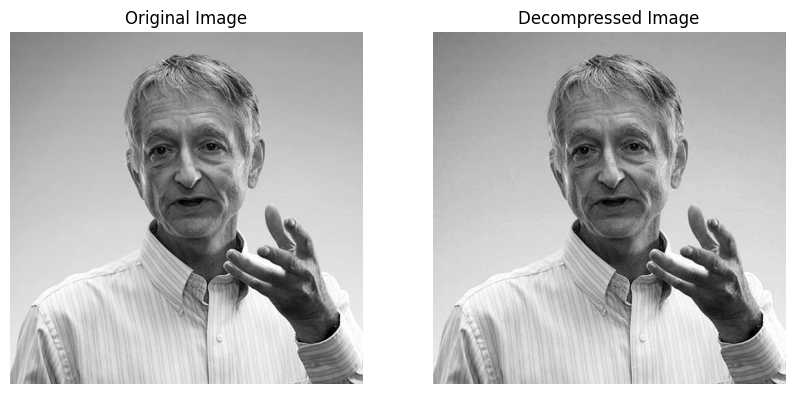

In [67]:
if __name__ == "__main__":
    # Load grayscale image
    image = cv2.imread('realImage.jpg', cv2.IMREAD_GRAYSCALE)
    if image is None:
        raise FileNotFoundError("Image 'realimage.jpg' not found.")
    
    # Step 1: Apply DCT
    dct_blocks = apply_dct(image)
    
    # Step 2: Quantize
    quantized_blocks = quantize(dct_blocks)
    
    # Step 3: Convert one block to vector (example with first block)
    sample_block = quantized_blocks[0:8, 0:8]
    jpeg_vector = mat_2_vec(sample_block)
    print("Sample zigzag vector:", jpeg_vector)
    
    # Step 4: Apply inverse DCT
    decompressed_image = apply_idct(quantized_blocks)
    
    # Display original and decompressed images
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.title("Original Image")
    plt.imshow(image, cmap='gray')
    plt.axis('off')
    plt.subplot(1, 2, 2)
    plt.title("Decompressed Image")
    plt.imshow(decompressed_image, cmap='gray')
    plt.axis('off')
    plt.show()
